In [90]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from vae import VAE
from dataset_preprocessor import PolarSpectrogramExtractor, AudioDatasetFromCSV

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
extractor = PolarSpectrogramExtractor(1024, 256)

In [4]:
dataset_params = {
    'spectrogram_extractor': extractor,
    'metadata_csv': './dataset_metadata.csv',
    'validation_size': .1,
    'sr': 22050,
    'prepared': True
}

data = AudioDatasetFromCSV(**dataset_params)

In [5]:
data.prepare_dataset()
data.train_test_split()


                Dataset has already been prepared. To finish preparing data for
                training use dataset.train_test_split(). To rerun dataset preparation, 
                you must first set the 'prepared' attribute to False.
                
Length of Training Data: 2377
Length of Testing Data: 265


# Build Variational Autoecoder
This model was taken with only slight changes from a variational autoencoder used by Valerio Valeras for generating spoken digits with variational autoencoders. The performance was not comparable to 

In [6]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 100

vae = VAE(
    input_shape=(512, 256, 1),
    conv_filters=(64, 64, 32, 32, 16),
    conv_kernels=(3, 3, 3, 3, 3),
    conv_strides=(2, 2, 2, 2, (2, 1)),
    latent_space_dim=256,
    reconstruction_loss_weight=100_000)

vae.compile(LEARNING_RATE)
vae.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 256, 128, 64  640         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 256, 128, 64  0           ['encoder_conv_layer_1[0][0]']   
                    

In [ ]:
vae_history = vae.model.fit(data.x_train_rho, 
                            data.y_train_rho, 
                            validation_data=(data.x_test_rho, data.y_test_rho), 
                            epochs=75,
                            batch_size=32
                           )

In [14]:
vae.model.save_weights("256_vae_weights.h5")

2023-06-12 04:04:56.333269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 04:04:56.432492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
pd.DataFrame(vae_history.history).to_csv("256_vae_history.csv")

In [9]:
df = pd.read_csv("./256_vae_history.csv")

In [7]:
vae.model.load_weights("./256_vae_weights.h5")

Metal device set to: Apple M1


2023-06-12 04:53:21.436051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-12 04:53:21.436506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-12 04:53:21.502509: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-12 04:53:21.504043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 04:53:21.580817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 04:53:21.843021: I tensorflow/core/grappler/o

# Plot Training History

Text(0.5, 1.0, 'Combined VAE Training Loss')

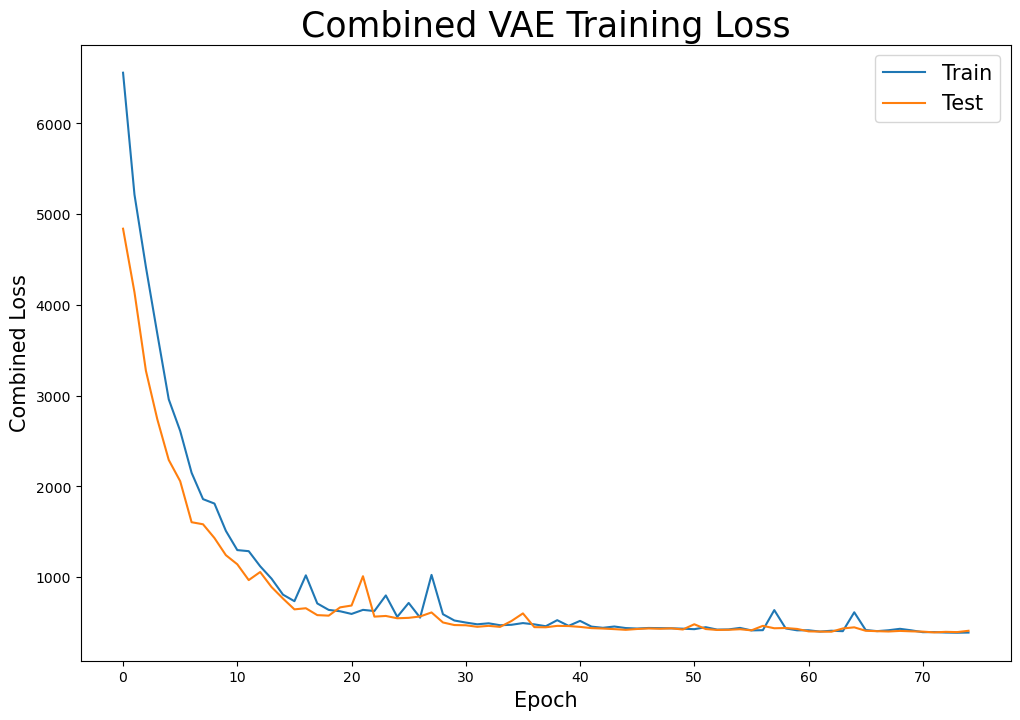

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(df['loss'], label="Train")
plt.plot(df['val_loss'], label="Test")
plt.legend(fontsize=15)
plt.xlabel("Epoch", size=15)
plt.ylabel("Combined Loss", size=15)
plt.title("Combined VAE Training Loss", size=25)

Text(0.5, 1.0, 'Reconstruction Loss')

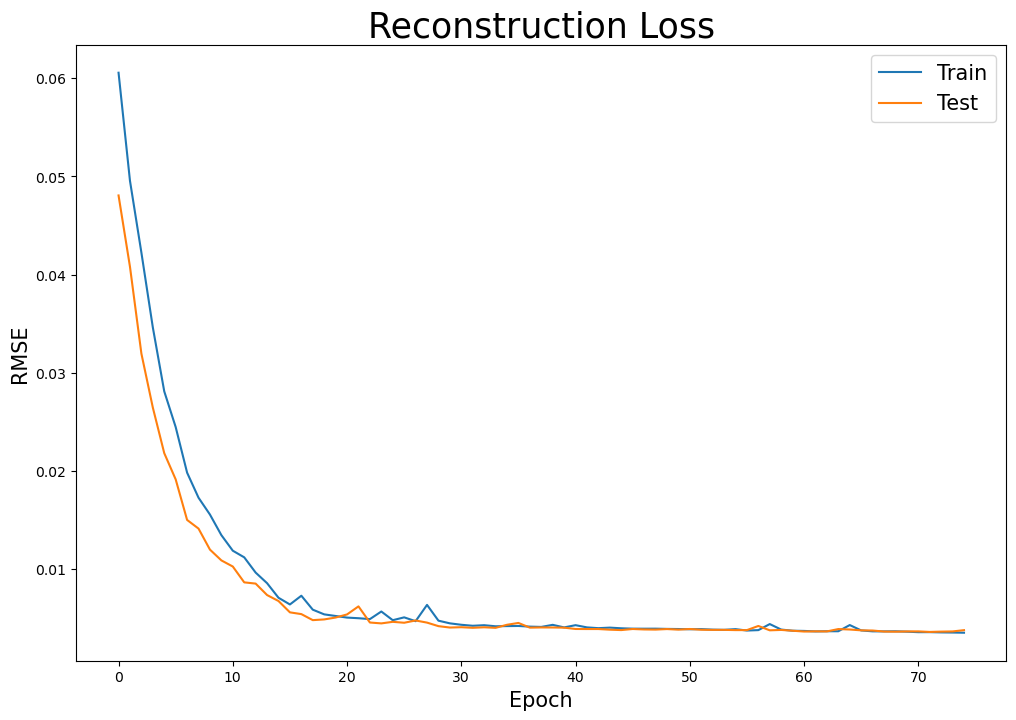

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(df['rmse_reconstruction_loss'], label="Train")
plt.plot(df['val_rmse_reconstruction_loss'], label="Test")
plt.legend(fontsize=15)
plt.xlabel("Epoch", size=15)
plt.ylabel("RMSE", size=15)
plt.title("Reconstruction Loss", size=25)

Text(0.5, 1.0, 'Kullback Leibler Loss')

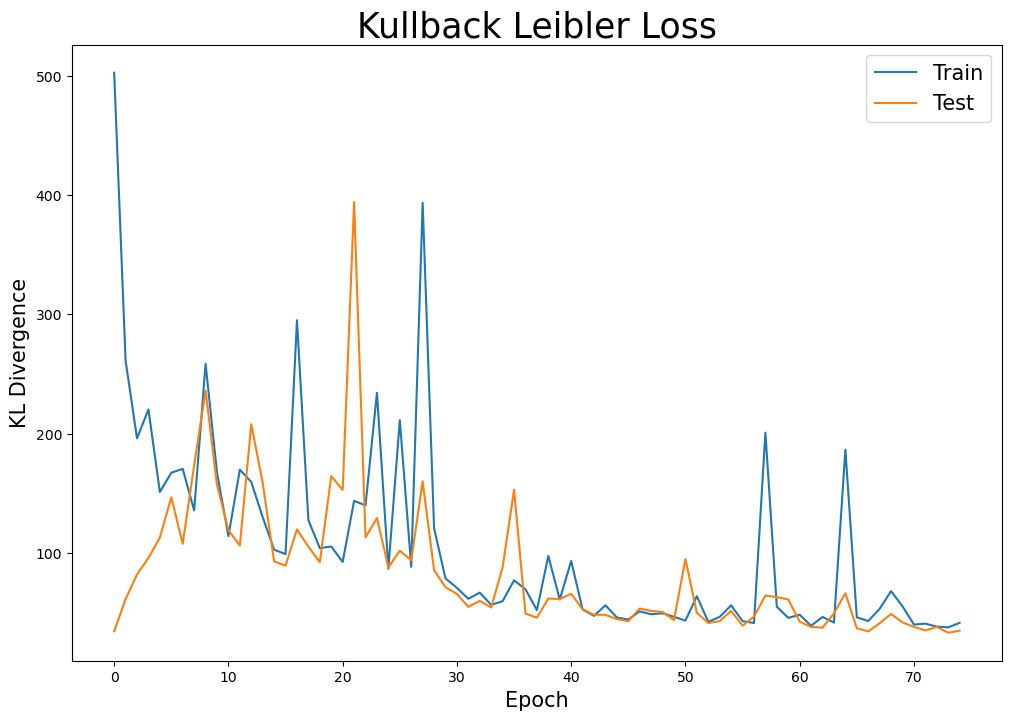

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(df['_calculate_kl_loss'], label="Train")
plt.plot(df['val__calculate_kl_loss'], label="Test")
plt.legend(fontsize=15)
plt.xlabel("Epoch", size=15)
plt.ylabel("KL Divergence", size=15)
plt.title("Kullback Leibler Loss", size=25)

In [32]:
reconstructed_specs, latent_representations = vae.reconstruct(data.x_test_rho)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-12 05:04:16.963666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-12 05:04:19.231367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Latent Representations
The latent representations of the vae are really nicely normalized, using all of the available latent dimensions and using them very evenly. The scatterplot below clearly resembles a multidimensional normal distribution collapsed into 2d space.

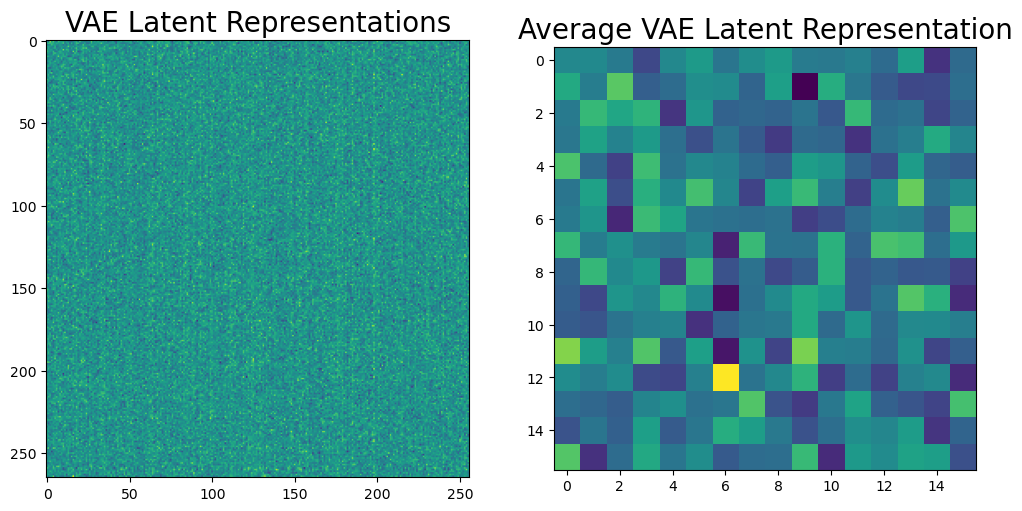

In [151]:
avg_latent = latent_representations.mean(axis=0)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("VAE Latent Representations", size=20)
axs[0].imshow(latent_representations)
axs[1].imshow(avg_latent.reshape(16, 16))
axs[1].set_title("Average VAE Latent Representation", size=20)
plt.tight_layout
plt.savefig("./images/vae_latent_average.png");

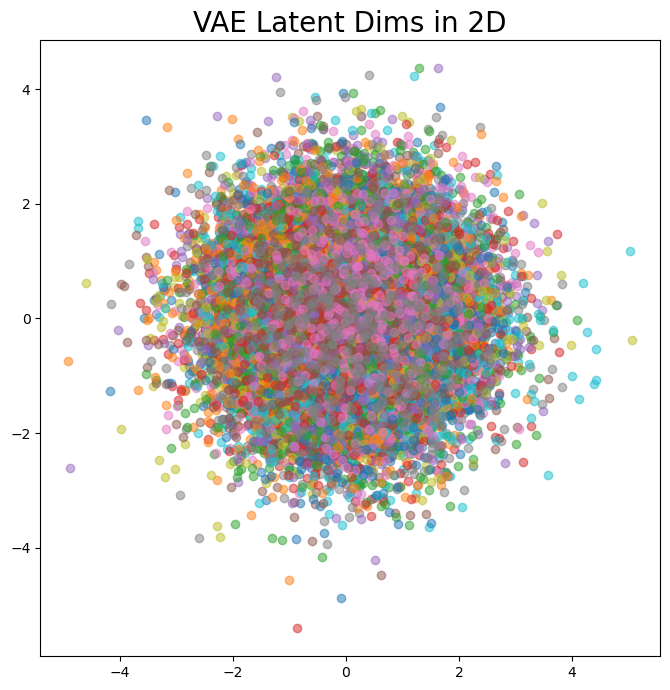

In [152]:
latent_trans = latent_representations.T
plt.figure(figsize=(8, 8))
plt.title("VAE Latent Dims in 2D", size=20)
for i in range(0, len(latent_trans), 2):
    plt.scatter(latent_trans[i], latent_trans[i+1], alpha=0.5)
plt.savefig("./images/vae_latent_scatter.png");

# Get Predictions

In [86]:
rho_preds = np.concatenate([reconstructed_specs, data.x_test_theta], axis=-1)

In [111]:
rho_preds = vae.model.predict(data.x_test_rho)

In [112]:
x_preds = np.concatenate([rho_preds, data.x_test_theta], axis=-1)

In [222]:
def pred_vs_target(extractor, x_preds, dataset, idx=None):
    
    if not idx:
        idx = np.random.randint(low=0, high=len(x_preds))
    
    rho = x_preds[idx]
    theta = dataset.x_test_theta[idx]
    spec = np.concatenate([rho, theta], axis=-1)
    y_true = dataset.y_test[idx]
    noisy = data.x_test[idx]
    
    noisy_signal = extractor.recover_signal(noisy)
    pred_signal = extractor.recover_signal(spec)
    orig_signal = extractor.recover_signal(y_true)
    
    print(f"Sample number {idx}")
    
    print("Noisy Audio")
    display(Audio(data=noisy_signal, rate=22050))
    display(plt.imshow(data.x_test_rho[idx],origin="lower"))
    plt.axis('off');
    plt.show()
    print("Regenerated Audio")
    display(Audio(data=pred_signal, rate=22050))
    display(plt.imshow(rho[...,0],origin="lower"))
    plt.axis('off');
    plt.show()
    print("Clean Audio")
    display(Audio(data=orig_signal, rate=22050))
    display(plt.imshow(data.y_test_rho[idx],origin="lower"))
    plt.axis('off');
    plt.show()

# Visualize Spectrograms
While the latent space distributions were very nicely formed, it come as the cost of loing all definition in the audio itself as predictions are pulled toward an average signal. This prediction will undoubtedly sound unrecognizable

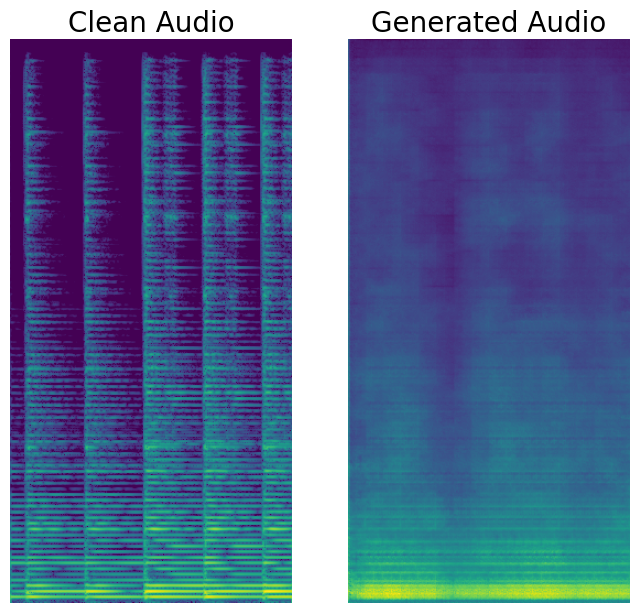

In [220]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs[0].imshow(data.y_test_rho[23], origin="lower")
axs[1].imshow(x_preds[23][...,0], origin="lower")
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Clean Audio', size=20)
axs[1].set_title('Generated Audio', size=20);

Sample number 255
Noisy Audio


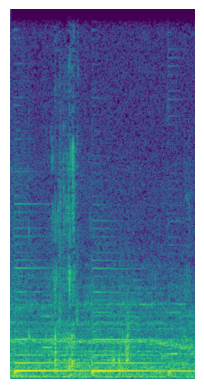

Regenerated Audio


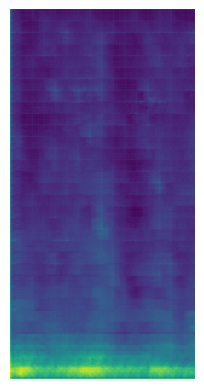

Clean Audio


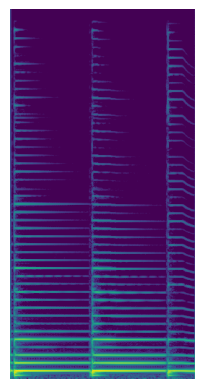

In [224]:
pred_vs_target(extractor, x_preds, data)